In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from textblob import TextBlob
import matplotlib.pyplot as plt
# Download NLTK resources
#nltk.download('punkt')
#nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import keras_tuner as kt


In [4]:
from sqlalchemy import create_engine

# Define your PostgreSQL connection parameters
db_user = 'postgres'
db_password = 'admin'
db_host = 'localhost'
db_port = '5433'
db_name = 'postgres'

# Create a SQLAlchemy engine to connect to the PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')


In [6]:
# Define your SQL query. You can modify this query to filter rows as needed.
query = """
SELECT *
FROM playstore_game_reviews
LIMIT 100000;  -- adjust this limit based on your memory and needs
"""

# Read the query results into a DataFrame
df = pd.read_sql(query, engine)

print("Subset of data loaded into DataFrame:")
print(df.head())

Subset of data loaded into DataFrame:
                                               title  \
0  Stickman Legends: Shadow War Offline Fighting ...   
1  Stickman Legends: Shadow War Offline Fighting ...   
2  Stickman Legends: Shadow War Offline Fighting ...   
3  Stickman Legends: Shadow War Offline Fighting ...   
4  Stickman Legends: Shadow War Offline Fighting ...   

                                         description  \
0  Do you know what interesting things are waitin...   
1  Do you know what interesting things are waitin...   
2  Do you know what interesting things are waitin...   
3  Do you know what interesting things are waitin...   
4  Do you know what interesting things are waitin...   

                                             summary  minInstalls   genre  \
0  Fight Greatest Battles Against Evils In This O...     10000000  Action   
1  Fight Greatest Battles Against Evils In This O...     10000000  Action   
2  Fight Greatest Battles Against Evils In This O...     

In [8]:
df.head()

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score
0,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOHHhBznEeiXTiHXEM-_cP3ja0PHlV2tfLc2nHE...,Jc Salandanan,This is one of the best game that I have ever ...,4
1,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOH8ALCxty8SZETdqAA6Zg9srKA-yJrwWPCpGE-...,cool gamers,it's very cool and nice really nice carpeters,4
2,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOG2vYFRHUaFSyapnS5dKjZ_obO9b6wItwuNAqQ...,Nilay Das,Why the change my first time mission man plez ...,4
3,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOFCs-jS5ltF2AaCjktGkocQLoi_CPcU6KgJpBb...,Player,This Game is Amazing!,4
4,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOFtIcahN5oCSKl5_At0KUu7Fkzs0AJZFcRDvWI...,Harsh Lakhanpal,What kind of this game I play it first time,4


In [10]:
# Standard English stopwords
standard_stopwords = set(stopwords.words('english'))

# Domain-specific stopwords for movie reviews (extend as needed)
domain_stopwords = {"game", "app", "play", "install","downloads"}

# Combined stopwords
all_stopwords = standard_stopwords.union(domain_stopwords)

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_review(text, method='lemmatization', do_spell_correction=True, min_words=3):
  
    # Handle missing or non-string values
    if not isinstance(text, str):
        return ""
    
    # Remove HTML tags if any
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', ' ', text).lower()
    
   # To remove emojis
    text = emoji.demojize(text)
    
    tokens = text.split()
    
    # Filter out tokens that are in our stopwords list
    tokens = [word for word in tokens if word not in all_stopwords]
    
    # Ensure the review has a minimum number of words; otherwise, mark as empty.
    if len(tokens) < min_words:
        return ""
    
    # Apply stemming or lemmatization as desired
    if method == 'stemming':
        tokens = [stemmer.stem(word) for word in tokens]
    else:  # default is lemmatization
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)


df['cleaned_review'] = df['content'].apply(clean_review)
df.head()

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score,cleaned_review
0,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOHHhBznEeiXTiHXEM-_cP3ja0PHlV2tfLc2nHE...,Jc Salandanan,This is one of the best game that I have ever ...,4,one best ever played
1,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOH8ALCxty8SZETdqAA6Zg9srKA-yJrwWPCpGE-...,cool gamers,it's very cool and nice really nice carpeters,4,cool nice really nice carpeters
2,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOG2vYFRHUaFSyapnS5dKjZ_obO9b6wItwuNAqQ...,Nilay Das,Why the change my first time mission man plez ...,4,change first time mission man plez answer
3,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOFCs-jS5ltF2AaCjktGkocQLoi_CPcU6KgJpBb...,Player,This Game is Amazing!,4,
4,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOFtIcahN5oCSKl5_At0KUu7Fkzs0AJZFcRDvWI...,Harsh Lakhanpal,What kind of this game I play it first time,4,kind first time


In [12]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_rating(text):
    sentiment = sid.polarity_scores(text)
    # VADER compound score is in [-1, 1]. We'll map it to a 1-5 scale.
    compound = sentiment['compound']
    rating = np.interp(compound, [-1, 1], [1, 5])
    return rating

In [20]:
if 'rating' not in df.columns or df['rating'].isnull().any():
    df['inferred_rating'] = df['cleaned_review'].apply(get_sentiment_rating)
    df['rating'] = df['inferred_rating']
    
df.head(10)

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score,cleaned_review,inferred_rating,rating
0,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOHHhBznEeiXTiHXEM-_cP3ja0PHlV2tfLc2nHE...,Jc Salandanan,This is one of the best game that I have ever ...,4,one best ever played,4.5300,4.5300
1,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOH8ALCxty8SZETdqAA6Zg9srKA-yJrwWPCpGE-...,cool gamers,it's very cool and nice really nice carpeters,4,cool nice really nice carpeters,4.5690,4.5690
2,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOG2vYFRHUaFSyapnS5dKjZ_obO9b6wItwuNAqQ...,Nilay Das,Why the change my first time mission man plez ...,4,change first time mission man plez answer,3.0000,3.0000
3,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOFCs-jS5ltF2AaCjktGkocQLoi_CPcU6KgJpBb...,Player,This Game is Amazing!,4,,3.0000,3.0000
4,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOFtIcahN5oCSKl5_At0KUu7Fkzs0AJZFcRDvWI...,Harsh Lakhanpal,What kind of this game I play it first time,4,kind first time,4.0534,4.0534
5,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOHvSun4acGM-2eRCa-y_HJtruTQ-KEBlW0LqPH...,Chris Abril,"so far it's good, nice game.",4,far good nice,4.3816,4.3816
6,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOFYfv5j1L7pft7I1U-Sg1cZ1nr3jIvck9BoVGt...,professional gamer,"like a famous tiger once said""GRRRRRRRREAT""",4,like famous tiger said grrrrrrrreat,3.7224,3.7224
7,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOGp1rwuxnapRMz2eWVu_LpJZsoEku0jntLGsXk...,A Google user,it was great time killer for me..✔,4,great time killer,2.8968,2.8968
8,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOFYQfE1WvfTeufZ1KGNXS-nnM4s0kEOY5H67zi...,Luidjy Theodore,it's cool to kill the emeys and the cool ticks...,4,cool kill emeys cool tick cool,3.1032,3.1032
9,Stickman Legends: Shadow War Offline Fighting ...,Do you know what interesting things are waitin...,Fight Greatest Battles Against Evils In This O...,10000000,Action,GAME_ACTION,com.zitga.ninja.stickman.legends.shadow.wars,gp:AOqpTOHFXdjjgdp8_CQJy5WzbogvJY3ZPR8CFChAVjM...,Tech & Gaming Insaan,I enjoy this game,4,,3.0000,3.0000


In [22]:
# Encode user and app IDs 
user_ids = df['userName'].unique().tolist()  # Unique user names
app_ids = df['appId'].unique().tolist()  # Unique app IDs

# Create mappings from user and app IDs to numeric indices
user2idx = {user: idx for idx, user in enumerate(user_ids)}
app2idx = {app: idx for idx, app in enumerate(app_ids)}

# Apply mappings to create numerical indices
df['user_idx'] = df['userName'].map(user2idx)
df['app_idx'] = df['appId'].map(app2idx)


In [90]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_vocab = 10000
max_length = 200

tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_review'])
df['review_seq'] = tokenizer.texts_to_sequences(df['cleaned_review'])
df['review_seq'] = pad_sequences(df['review_seq'], maxlen=max_length).tolist()





In [91]:
# Prepare training data 
X_user = np.array(df['user_idx'].tolist())
X_app = np.array(df['app_idx'].tolist())  
X_review = np.array(df['review_seq'].tolist())

y = np.array(df['rating'].tolist())

print("User input shape:", X_user.shape)
print("App input shape:", X_app.shape)      
print("Review input shape:", X_review.shape)
print("Ratings shape:", y.shape)


User input shape: (100000,)
App input shape: (100000,)
Review input shape: (100000, 200)
Ratings shape: (100000,)


In [92]:
# Split the data into training and testing sets
X_user_train, X_user_test, X_app_train, X_app_test, X_review_train, X_review_test, y_train, y_test = train_test_split(
    X_user, X_app, X_review, y, test_size=0.2, random_state=42
)

In [96]:

#  Load Pre-trained GloVe Embeddings



glove_file = 'glove.6B.100d.txt'  

# Create a dictionary mapping words to their GloVe vector
embedding_dim = 100  # using 100-dim embeddings from GloVe
embeddings_index = {}
with open(glove_file, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
        
# Prepare embedding matrix for our vocabulary
word_index = tokenizer.word_index  # from our tokenizer created earlier
num_words = min(max_vocab, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_vocab:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [98]:

#  Custom Attention Layer


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='context_vector',
                                 shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        u_it = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch, time_steps, hidden_size)
        # Compute attention scores as a weighted sum over the features
        att = K.sum(u_it * self.u, axis=-1)  # (batch, time_steps)
        att_weights = K.softmax(att)  # (batch, time_steps)
        weighted_input = inputs * K.expand_dims(att_weights, -1)
        output = K.sum(weighted_input, axis=1)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [100]:
num_users = len(user2idx)
num_apps = len(app2idx)   
embedding_size = 10  

# User Input and embedding
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
user_vec = Flatten(name='user_flatten')(user_embedding)


In [102]:
def build_model(hp):
    # Input layers
    user_input = Input(shape=(1,), name='user_input')
    app_input = Input(shape=(1,), name='app_input') 
    review_input = Input(shape=(max_length,), name='review_input')
    
    # User embedding 
    user_embedding_dim = hp.Choice('user_embedding_dim', values=[8, 10, 12, 16, 20])
    user_embedding = Embedding(input_dim=len(user2idx), output_dim=user_embedding_dim, name='user_embedding')(user_input)
    user_vec = Flatten(name='user_flatten')(user_embedding)
    
    # App embedding 
    app_embedding_dim = hp.Choice('app_embedding_dim', values=[8, 10, 12, 16])
    app_embedding = Embedding(input_dim=len(app2idx), output_dim=app_embedding_dim, name='app_embedding')(app_input)
    app_vec = Flatten(name='app_flatten')(app_embedding)
    
    # Review embedding using pre-trained GloVe embeddings (frozen)
    review_embedding = Embedding(input_dim=num_words,
                                 output_dim=embedding_dim,
                                 weights=[embedding_matrix],
                                 input_length=max_length,
                                 trainable=False,
                                 name='review_embedding')(review_input)
    
    # LSTM layer on review text
    lstm_units = hp.Choice('lstm_units', values=[50, 100, 150])
    lstm_out = LSTM(lstm_units, return_sequences=True, name='lstm_layer')(review_embedding)
    
    # Attention layer to focus on important words
    att_out = AttentionLayer(name='attention_layer')(lstm_out)
    
    # Concatenate all features
    concat = Concatenate(name='concatenate')([user_vec, app_vec, att_out])
    
    # Dense layers: choose number of units and dropout rate
    dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    dense1 = Dense(dense_units, activation='relu', name='dense1')(concat)
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    dropout_layer = Dropout(dropout_rate, name='dropout')(dense1)
    
    dense2 = Dense(dense_units // 2, activation='relu', name='dense2')(dropout_layer)
    output = Dense(1, activation='linear', name='rating_prediction')(dense2)
    
    model = Model(inputs=[user_input, app_input, review_input], outputs=output)
    
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir_play_store',
    project_name='app_rec_tuning'  # updated project name to reflect the new domain
)


Reloading Tuner from tuner_dir_play_store\app_rec_tuning\tuner0.json


In [104]:
# Run the hyperparameter search
tuner.search([X_user_train, X_app_train, X_review_train], y_train,
             validation_split=0.1,
             epochs=5,
             batch_size=64)

In [106]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"User Embedding Dim: {best_hps.get('user_embedding_dim')}")
print(f"App Embedding Dim: {best_hps.get('app_embedding_dim')}")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

Best hyperparameters:
User Embedding Dim: 16
App Embedding Dim: 8
LSTM Units: 150
Dense Units: 160
Dropout Rate: 0.0
Learning Rate: 0.00036265062575473466


In [108]:
# Build the best model and train it longer
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    [X_user_train, X_app_train, X_review_train],
    y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64
)

C:\Users\alanb\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 440s 380ms/step - loss: 1.6813 - mae: 0.8466 - val_loss: 0.2519 - val_mae: 0.3253
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 419s 372ms/step - loss: 0.2194 - mae: 0.3084 - val_loss: 0.2115 - val_mae: 0.3121
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 408s 363ms/step - loss: 0.1058 - mae: 0.2081 - val_loss: 0.2093 - val_mae: 0.3173
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 408s 363ms/step - loss: 0.0518 - mae: 0.1406 - val_loss: 0.1938 - val_mae: 0.2659
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 417s 370ms/step - loss: 0.0340 - mae: 0.1106 - val_loss: 0.1942 - val_mae: 0.2674
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 428s 380ms/step - loss: 0.0274 - mae: 0.1007 - val_loss: 0.1876 - val_mae: 0.2572
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2686s 2s/step - loss: 0.0249 - mae: 0.0955 - val_loss: 0.1799 - val_mae: 0.2590
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 352s 313ms/step - loss: 0.0224 - mae: 0.0906 - val_loss: 0.1733 - val_mae: 0.2497
Epoch 9/10

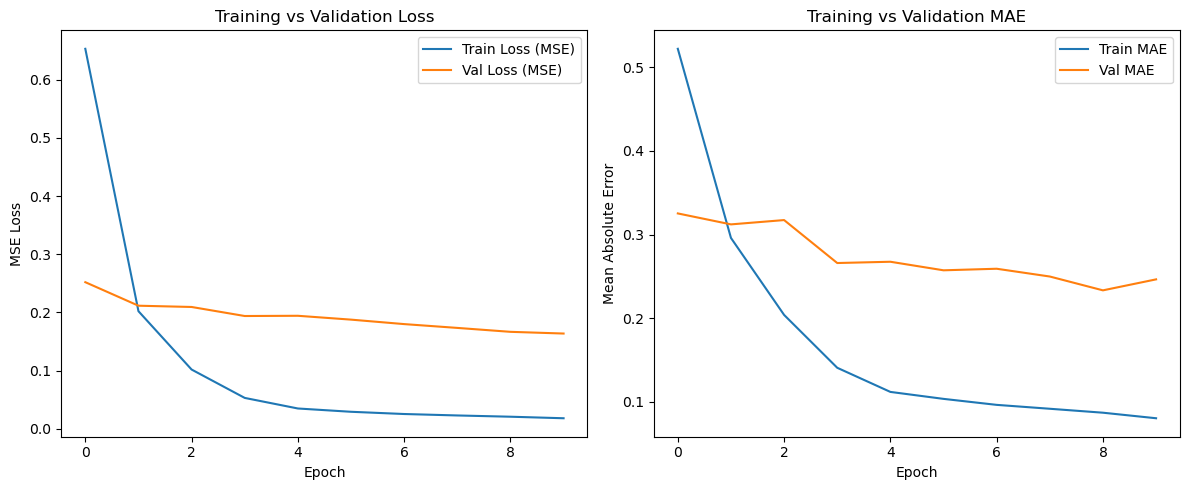

In [110]:
# Plot training and validation loss and MAE
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


In [112]:
# Evaluate on the test set
loss, mae = best_model.evaluate([X_user_test, X_app_test, X_review_test], y_test)
print(f"Test MSE: {loss:.4f}, Test MAE: {mae:.4f}")



625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - loss: 0.1650 - mae: 0.2467
Test MSE: 0.1678, Test MAE: 0.2492


625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step


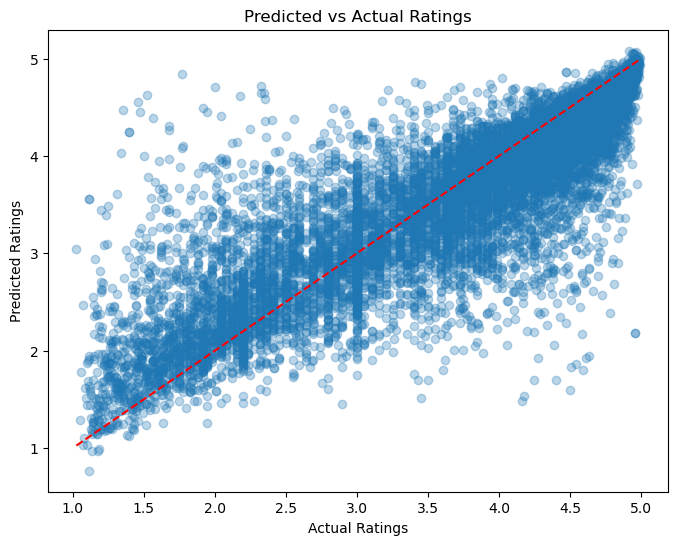

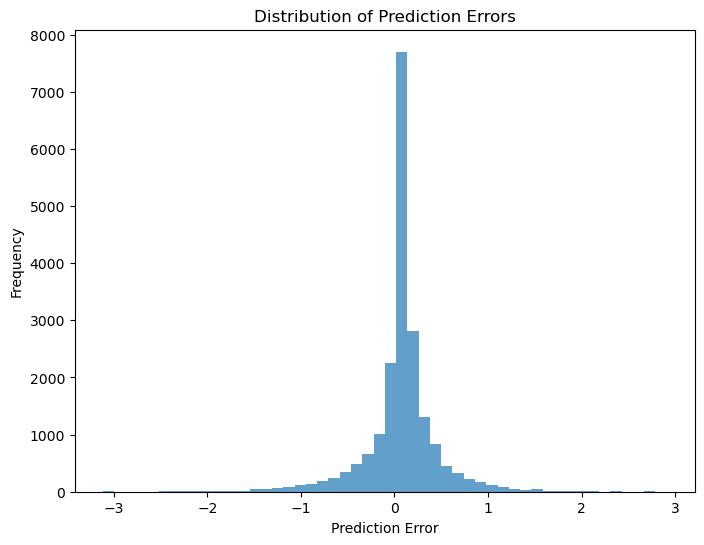

In [114]:
# ----- Error Analysis -----
# Generate predictions on test set
y_pred = best_model.predict([X_user_test, X_app_test, X_review_test]).flatten()

# Plot predicted vs actual ratings
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # reference line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()

# Plot error distribution
errors = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=50, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()



In [116]:
# Create a DataFrame to inspect some of the predictions
test_df = pd.DataFrame({
    'user': X_user_test, 
    'app': X_app_test, 
    'true_rating': y_test, 
    'predicted_rating': y_pred
})

print(test_df.head())

    user  app  true_rating  predicted_rating
0  66222   40       3.0888          3.599554
1  70025   42       3.5032          4.166013
2  17749    8       3.0000          2.955498
3  67052   40       3.0000          2.972634
4  80817   64       3.0000          2.896102


In [60]:
def recall_ndcg(test_df, k=10, relevance_threshold=3.0):
  
    # Group the results by user
    user_groups = test_df.groupby('user')
    
    precisions = []
    recalls = []
    ndcgs = []
    
    for user, group in user_groups:
        # Sort the user's items by predicted rating in descending order
        group_sorted = group.sort_values('predicted_rating', ascending=False)
        top_k = group_sorted.head(k)
        
        # Determine relevant items (true rating above threshold)
        relevant = (top_k['true_rating'] >= relevance_threshold).astype(int).values
        num_relevant_in_top_k = relevant.sum()
        
      
        
        # Total number of relevant items for the user in the test set
        total_relevant = (group['true_rating'] >= relevance_threshold).sum()
        recall = num_relevant_in_top_k / total_relevant if total_relevant > 0 else 0.0
        
        # Calculate DCG@K
        dcg = sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(relevant)])
        
        # Calculate Ideal DCG (IDCG@K)
        ideal_relevances = group['true_rating'].apply(lambda x: 1 if x >= relevance_threshold else 0)
        ideal_sorted = ideal_relevances.sort_values(ascending=False).head(k).values
        idcg = sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(ideal_sorted)])
        
        ndcg = dcg / idcg if idcg > 0 else 0.0
        
       
        recalls.append(recall)
        ndcgs.append(ndcg)
    
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_ndcg = np.mean(ndcgs)
    
    return avg_precision, avg_recall, avg_ndcg


In [62]:
# Set k (e.g., 10) and a relevance threshold (e.g., 3.0)
k = 10
relevance_threshold = 3.0

avg_precision, avg_recall, avg_ndcg = precision_recall_ndcg(test_df, k=k, relevance_threshold=relevance_threshold)

print(f"Precision@{k}: {avg_precision:.4f}")
print(f"Recall@{k}: {avg_recall:.4f}")
print(f"NDCG@{k}: {avg_ndcg:.4f}")

Precision@10: 0.0859
Recall@10: 0.8440
NDCG@10: 0.8440


In [64]:
# Mapping app IDs to titles
app_id_to_title = df[['appId', 'title']].drop_duplicates().set_index('appId')['title'].to_dict()


In [68]:
# Example: Predict ratings for a sample user (e.g., user index 7) for all apps
sample_user = 7
num_apps = len(app2idx)  
all_app_indices = np.array(list(range(num_apps)))
sample_user_input = np.full(shape=(num_apps,), fill_value=sample_user)

default_review_seq = np.zeros((num_apps, max_length), dtype=int)

predicted_ratings = best_model.predict([sample_user_input, all_app_indices, default_review_seq]).flatten()
recommended_app_indices = np.argsort(predicted_ratings)[::-1][:10]  # Top 10 recommendations

recommended_app_titles = [app_id_to_title[app_ids[i]] for i in recommended_app_indices]

print("Top recommended app titles for user", sample_user, "using the model:")
for title in recommended_app_titles:
    print(title)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Top recommended app titles for user 7 using the model:
Lifeline: Flatline
Solitaire+
Lucky Leprechaun Slots PAID
Galaxy Shooter : Falcon Squad Premium
Hidden Folks
Ticket to Ride
Carcassonne: Official Board Game -Tiles & Tactics
Alien: Blackout
Galaxy Attack: Alien Shooter (Premium)
Dr. Panda School
